# LSTM Neural Network to predict stock movement
This is a neural network that takes in the past however many candlesticks worth of information and uses that to predict the next close price. Currently it the information fed to it needs to be a csv in the format `snapshotTimeUTC,openPrice,highPrice,lowPrice,closePrice,lastTradedVolume`.\
It uses LSTM networks to try and get the neural network to understand complex patterns and trends that are present in stock prices

In [1]:
%pip install scikit-learn pandas numpy keras matplotlib keras-tuner tensorflow
# INSTALL TENSORFLOW SEPARATELY pip install "tensorflow<2.11" if on windows
# IF YOU HAVE GPU RECOMMEND INSTALL CUDA AND CUDNN

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.4/159.4 kB 3.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 47.5 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 48.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 54.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.0/306.0 kB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 58.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 100.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 57.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 505.5/505.5 kB 78.3 MB

In [3]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.mixed_precision import set_global_policy
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input
import random
from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch

In [4]:
import tensorflow as tf

# Check if GPU is available
# Trust me you prefer using a GPU for training
print("TensorFlow version:", tf.__version__)
print("Number of GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if tf.config.list_physical_devices('GPU'):
    print("Default GPU Device: {}".format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

TensorFlow version: 2.16.1
Number of GPUs Available:  1
Default GPU Device: /device:GPU:0


2024-04-05 21:14:40.569909: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /device:GPU:0 with 22283 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:c1:00.0, compute capability: 8.9


In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


2024-04-05 21:14:42.381485: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22283 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:c1:00.0, compute capability: 8.9


## Data preprocessing
The data is preprocessed by grouping information in groups of a set time step, currently its 100. Therefore the past 100 candlesticks of data will be used to predict the next one

In [6]:
# Group data into time steps and have the next value as the label
def create_dataset(dataset, time_step=100):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), :]
        dataX.append(a)
        dataY.append(dataset[i + time_step, -2])
    return np.array(dataX), np.array(dataY)

def preprocess_dataset(X, Y, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.cache()  # Cache data
    dataset = dataset.shuffle(buffer_size=len(X)).batch(batch_size)  # Shuffle and batch
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)  # Prefetch data
    return dataset

In [7]:
data = pd.read_csv('big.csv', parse_dates=['snapshotTimeUTC'])
data.set_index('snapshotTimeUTC', inplace=True)
features = data[['openPrice', 'highPrice', 'lowPrice', 'closePrice', 'lastTradedVolume']].values
data.head()

,openPrice,highPrice,lowPrice,closePrice,lastTradedVolume
snapshotTimeUTC,,,,,
2017-05-02 06:00:00,12449.8,12465.0,12439.0,12461.8,554
2017-05-02 06:05:00,12462.0,12467.0,12458.0,12459.0,260
2017-05-02 06:10:00,12459.5,12469.0,12459.5,12466.5,299
2017-05-02 06:15:00,12466.3,12466.5,12462.0,12464.5,216
2017-05-02 06:20:00,12464.5,12465.0,12461.8,12465.0,152


In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
normalised_features = scaler.fit_transform(features)
len(normalised_features)

392034

In [9]:
X, Y = create_dataset(normalised_features)

In [10]:
# Define the split point
split_point = int(len(X) * 0.8)

# Split the data into training and testing sets by slicing
X_train, X_test = X[:split_point, :, :], X[split_point:, :, :]
Y_train, Y_test = Y[:split_point], Y[split_point:]

batch_size = 64 
train_dataset = preprocess_dataset(X_train, Y_train, batch_size)
val_dataset = preprocess_dataset(X_test, Y_test, batch_size)

In [11]:
set_global_policy('mixed_float16')

## Hyperparameter tuning
In an attempt to optimise the model, I decided to tune the hyperparameters. I decided to test between 1 and 5 LSTM layers. Surprisingly the tuner consistently gave back that 1 layer with many units was optimal for every dataset I gave it. This also seemed to be the case when I was playing around with different model layers and hyperparameters

In [12]:
# Hyperparameter tuning
class LSTMHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape
    
    def build(self, hp):
        model = keras.Sequential()
        model.add(Input(shape=self.input_shape))
        
        # Tune the number of LSTM layers and the number of units in each layer
        for i in range(hp.Int('num_layers', 1, 5)):
            model.add(LSTM(units=hp.Int('units_' + str(i),
                                                     min_value=32,
                                                     max_value=512,
                                                     step=32),
                                         return_sequences=i < hp.get('num_layers') - 1))
            model.add(Dropout(hp.Float('dropout_' + str(i), 0.0, 0.5, step=0.1)))
            model.add(BatchNormalization())
        
        model.add(Dense(1))
        model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                      loss='mean_squared_error')

        model.optimizer = tf.keras.mixed_precision.LossScaleOptimizer(model.optimizer)
        
        return model

In [13]:
input_shape = (X_train.shape[1], 5)
hypermodel = LSTMHyperModel(input_shape=input_shape)

tuner = RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='random_search',
    project_name='big'
)

tuner.search(train_dataset, epochs=20, validation_data=val_dataset, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

Reloading Tuner from random_search/big/tuner0.json


In [14]:
model = tuner.get_best_models(num_models=1)[0]

best_hyperparameters = tuner.get_best_hyperparameters()[0]
best_hyperparameters.values

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 4 variables whereas the saved optimizer has 20 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


{'num_layers': 1,
 'units_0': 352,
 'dropout_0': 0.0,
 'learning_rate': 0.0001,
 'units_1': 320,
 'dropout_1': 0.2,
 'units_2': 288,
 'dropout_2': 0.1,
 'units_3': 224,
 'dropout_3': 0.1,
 'units_4': 512,
 'dropout_4': 0.2}

## Building the model manually
Here I tried many different models and played around with what seemed to work best. From my own testing the below model seemed to work best

In [23]:
model = keras.Sequential()
# First LSTM layer with Dropout regularisation
model.add(Input(shape=(X_train.shape[1], 5)))
model.add(LSTM(units=200, return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=120, return_sequences=True))
model.add(Dropout(0.1))

model.add(LSTM(units=80, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=40))
model.add(Dropout(0.3))

model.add(Dense(units=1))


model.compile(optimizer='adam',loss='mean_squared_error')

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 352)            │       504,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 352)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 352)            │         1,408 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           353 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 505,825 (1.93 MB)

 Trainable params: 505,121 (1.93 MB)

 Non-trainable params: 704 (2.75 KB)

In [28]:
# Stop training if validation loss does not improve for 5 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_dataset, epochs=100, batch_size=32, validation_data=val_dataset, callbacks=[early_stopping])

Epoch 1/100
4900/4900 ━━━━━━━━━━━━━━━━━━━━ 46s 9ms/step - loss: 3.2326e-04 - val_loss: 5.6937e-05
Epoch 2/100
4900/4900 ━━━━━━━━━━━━━━━━━━━━ 47s 9ms/step - loss: 3.1370e-04 - val_loss: 9.0958e-06
Epoch 3/100
4900/4900 ━━━━━━━━━━━━━━━━━━━━ 46s 9ms/step - loss: 3.0775e-04 - val_loss: 3.2319e-05
Epoch 4/100
4900/4900 ━━━━━━━━━━━━━━━━━━━━ 46s 9ms/step - loss: 3.1290e-04 - val_loss: 4.1388e-05
Epoch 5/100
4900/4900 ━━━━━━━━━━━━━━━━━━━━ 47s 9ms/step - loss: 3.2187e-04 - val_loss: 1.8652e-06
Epoch 6/100
4900/4900 ━━━━━━━━━━━━━━━━━━━━ 46s 9ms/step - loss: 3.2308e-04 - val_loss: 5.4348e-07
Epoch 7/100
4900/4900 ━━━━━━━━━━━━━━━━━━━━ 46s 9ms/step - loss: 2.9974e-04 - val_loss: 2.3616e-06
Epoch 8/100
4900/4900 ━━━━━━━━━━━━━━━━━━━━ 45s 9ms/step - loss: 3.2555e-04 - val_loss: 1.4588e-04
Epoch 9/100
4900/4900 ━━━━━━━━━━━━━━━━━━━━ 44s 9ms/step - loss: 3.2304e-04 - val_loss: 5.8813e-05
Epoch 10/100
4900/4900 ━━━━━━━━━━━━━━━━━━━━ 46s 9ms/step - loss: 3.2571e-04 - val_loss: 6.1209e-05
Epoch 11/100
4900/4

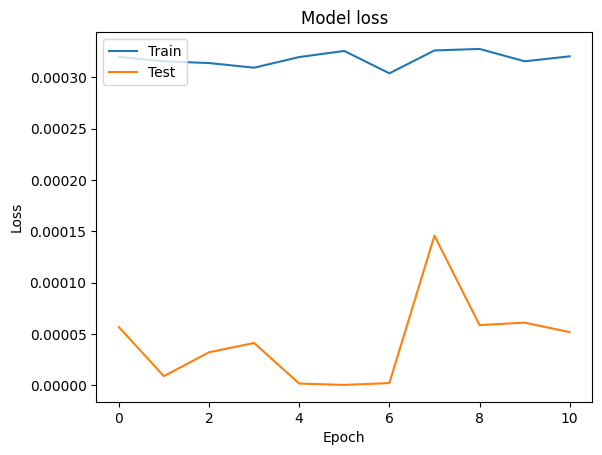

In [29]:
# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Plotting the stock price prediction next to the actual stock price
Here I'm plotting at each point what the AI thinks the next stock price is going to be.\
At each point it's using the past 100 actual stock price points therefore this is showing how accurate it is when predicting just the next price point.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


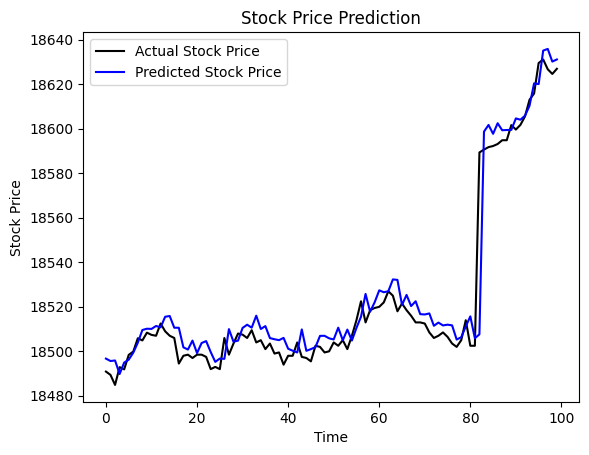

In [115]:
# Find a random place and predict those 50 prices 
# Plot the actual and predicted stock prices alongside each other

last_prices = 100

random_index = random.randint(0, len(X) - 50)
X_test = X[-last_prices:]
Y_test = Y[-last_prices:]
predictions = model.predict(X_test)

dummy_array = np.zeros_like(features[-last_prices:])
dummy_array[:, -2] = predictions.flatten()

predictions = scaler.inverse_transform(dummy_array)

dummy_array = np.zeros_like(features[-last_prices:])
dummy_array[:, -2] = Y_test.flatten()

actual = scaler.inverse_transform(dummy_array)

time_sequence = np.arange(len(actual))

plt.plot(time_sequence, actual[:, -2], color='black', label='Actual Stock Price',  markersize=4) 
plt.plot(time_sequence, predictions[:, -2], color='blue', label='Predicted Stock Price', markersize=4) 

plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## Predicting multiple prices in the future
Considering my model takes an input of 5 features, high, low, open, close, volume, I needed to use the models predictions to predict multiple stocks in the future.\
It works by setting the the high, low, open, close to the same predicted value and keeping the volume the same. It continuously predicts off its own predictions to get to the next one. This however is only accurate for a few prices in advance due to the accumulation in prediction error.

In [89]:
def predict_future_close_prices(model, initial_sequence, n_future_steps=10):
    future_prices = []
    current_sequence = np.array(initial_sequence) 
    
    for _ in range(n_future_steps):
        # Predict the next close price
        next_price_prediction = model.predict(current_sequence, verbose=0)[0, 0]
        
        # Append predicted close price to the list
        future_prices.append(next_price_prediction)
        
        # Update the sequence with the predicted close price
        # Set open, high, and low to the predicted close, keep the last known volume
        new_row = current_sequence[:, -1:, :].reshape(5)
        new_row[0] = new_row[1] = new_row[2] = new_row[3] = next_price_prediction  # open, high, low, close
        
        # Roll the sequence to simulate moving forward in time
        current_sequence = np.roll(current_sequence, -1, axis=1)
        current_sequence[:, -1:] = new_row.reshape(1, 1, 5)  # Insert new row
    
    return np.array(future_prices)


## Pick a random point in the data set and predict future
Here I'm picking a random spot and predicting n future prices in advance and show n previous steps to show the 

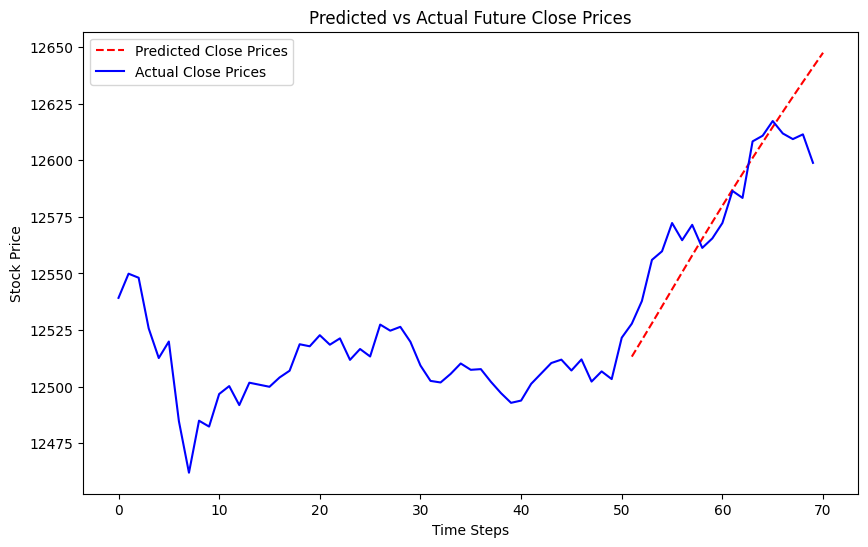

In [121]:
# Number of future steps you want to predict
n_future_steps = 20
n_previous_steps = 50

# Select a random starting point for prediction
max_start_index = len(X) - n_future_steps
random_start_index = random.randint(0, max_start_index)

# Get sequence at the random start index
initial_sequence = X[random_start_index:random_start_index + 1] 

predicted_prices = predict_future_close_prices(model, initial_sequence, n_future_steps=n_future_steps)

dummy_array = np.zeros((n_future_steps, 5))
dummy_array[:, -2] = predicted_prices
predicted_prices_scaled_back = scaler.inverse_transform(dummy_array)[:, 3]

actual_future_prices = Y[random_start_index + 1 - n_previous_steps:random_start_index + 1 + n_future_steps]

dummy_features_for_Y = np.zeros((n_future_steps+n_previous_steps, 5))  

dummy_features_for_Y[:, -2] = actual_future_prices  

actual_future_prices_scaled_back = scaler.inverse_transform(dummy_features_for_Y)[:, -2]  

time_sequence = np.arange(n_future_steps + n_previous_steps)
time_sequence_predicted = np.arange(n_previous_steps + 1, n_previous_steps + 1 + n_future_steps)

plt.figure(figsize=(10, 6))
plt.plot(time_sequence_predicted, predicted_prices_scaled_back, label='Predicted Close Prices', linestyle='--', color='red')
plt.plot(time_sequence, actual_future_prices_scaled_back, label='Actual Close Prices', linestyle='-', color='blue')
plt.title('Predicted vs Actual Future Close Prices')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()